In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

reset_graph()

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

# Q table

In [2]:
import gym
env = gym.make('FrozenLake-v0')
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.n)
print(env.observation_space)

[2017-08-29 13:01:46,009] Making new env: FrozenLake-v0


4
Discrete(4)
16
Discrete(16)


In [41]:
%%time
reset_graph()
Q = np.zeros([env.observation_space.n,env.action_space.n])
lr = .8
y = .95
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for epoch in range(4000):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a=np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(epoch+1)))
        # Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

CPU times: user 7.59 s, sys: 4 ms, total: 7.6 s
Wall time: 7.59 s


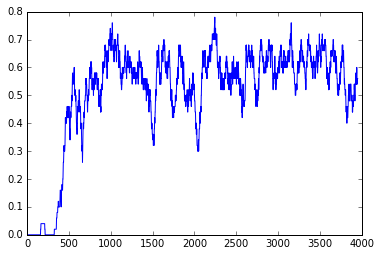

In [42]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

plt.plot(running_mean(rList,50))

# Tensorflow approach

In [18]:
reset_graph()

inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
#W = tf.Variable(tf.random_uniform([16,4],0,0.01))
#Qout = tf.matmul(inputs1,W)
# keepin the bias in the dense layer results in a dramatic decrease of performance...
Qout = tf.layers.dense(inputs1, 4, kernel_initializer=tf.random_uniform_initializer(0,0.01), use_bias=False)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

init = tf.global_variables_initializer()


In [19]:
rList = []
e = 0.1
y = .99
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(4000):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = True
        j = 0
        #The Q-Table learning algorithm
        while j < 99:
            j+=1
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            # Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            Q1 = sess.run([Qout],feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            sess.run(updateModel,feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((epoch/50) + 10)
                break
        rList.append(rAll)

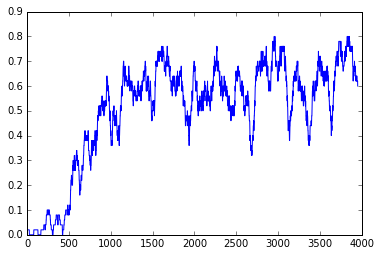

In [20]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

plt.plot(running_mean(rList,50))

# Tensorflow approach - with replay memory 

Keen to test the replay memory here as I expect it to solve the issue with biais

In [21]:
reset_graph()

inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
#W = tf.Variable(tf.random_uniform([16,4],0,0.01))
#Qout = tf.matmul(inputs1,W)
# keepin the bias in the dense layer results in a dramatic decrease of performance...
Qout = tf.layers.dense(inputs1, 4, kernel_initializer=tf.random_uniform_initializer(0,0.01), use_bias=False)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

init = tf.global_variables_initializer()


In [ ]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

myBuffer = experience_buffer()
batch_size = 32 #How many experiences to use for each training step.
rList = []
e = 0.1
y = .99
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(4000):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = True
        j = 0
        #The Q-Table learning algorithm
        while j < 99:
            j+=1
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            # Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            Q1 = sess.run([Qout],feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            sess.run(updateModel,feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((epoch/50) + 10)
                break
        rList.append(rAll)